# Import Libraries

In [1]:
import gurobipy as grb
import pandas as pd
from gurobipy import GRB
import numpy as np

# Model

In [2]:
 # Create a model
model = grb.Model("Model")

Restricted license - for non-production use only - expires 2024-10-28


# Get data from json

In [3]:
# get the  data from the json file small.json
import json
with open('small.json') as f:
    data = json.load(f)
# data

## Constants from data

In [4]:
horizon= data['horizon']
qualifications=data['qualifications']
staff_names=[i['name'] for i in data['staff']]
staff_qualifications=[i['qualifications'] for i in data['staff']]
job_list=[i['name'] for i in data['jobs']]
jour_list=[i for i in range(1,horizon+1)]
job_penality=[i['daily_penalty'] for i in data['jobs']] 
job_qualifications= [i['working_days_per_qualification'] for i in data['jobs']]
job_gain=[i['gain'] for i in data['jobs']]
due_dates=[i['due_date'] for i in data['jobs']]
vacation_staff=[i['vacations'] for i in data['staff']]

# Model's parameters

#### Objective 1
H : days

Q : qualifications

S : staff

J : jobs

qi : qualifications of i

qj : qualifications of j

vi : vacation days of i

njk : required work load for j with k

cj : daily penalty of j

gj : gain of j

dj : due date of j

yj : is j completely done

lj : delay in days for j

ej : end date of j

pi_j_k_t : work is done by i with k for j on t

#### Objective 2
aij : j is assigned to i

ni : number of jobs i works on

max_i : max of ni

### Objective 3
sj : start date for j

nj : length in days for j

max_j : maximum of nj

In [6]:
H = [i for i in range(1,horizon+1)]
Q = qualifications
S = staff_names
J = job_list
# Parameters for each staff

qi = {}
for i in range(len(staff_names)) :
    k = staff_names[i]
    qi[k] = []
    for c in qualifications:
        if c in data['staff'][i]['qualifications']:
            qi[k].append(c)
vi={}
for ind,i in enumerate(staff_names):
    vi[i] = []
    for j in jour_list:
        if j in vacation_staff[ind]:
            vi[i].append(j)
#vi=staff_in_vacation.to_dict(orient='index')

# Parameters for each job
qj = dict()
for ind, j in enumerate(job_list):
    qj[j] = list(job_qualifications[ind].keys())
njk = dict(zip(job_list,job_qualifications))
cj=job_penality_dict=dict(zip(job_list,job_penality))
gj=job_gain_dict=dict(zip(job_list,job_gain))
dj = dict(zip(job_list,due_dates))


# Decision variables

In [7]:
# Objective 1
pijkt = model.addVars(staff_names,job_list,qualifications,jour_list, vtype=GRB.BINARY, name="pijkt")

yj = model.addVars(job_list, vtype=GRB.BINARY, name="yj")
lj = model.addVars(job_list, vtype=GRB.INTEGER, name="lj")
ej = model.addVars(job_list, vtype=GRB.INTEGER, name="ej")

# Objective 2
max_i = model.addVar(vtype=GRB.INTEGER, name="max_i")
ni = model.addVars(S, vtype=GRB.INTEGER, name="ni")
aij = model.addVars(S, J, vtype=GRB.BINARY, name="aij")

# Objective 3
sj = model.addVars(J, vtype=GRB.INTEGER, name="sj")
nj = model.addVars(J, vtype=GRB.INTEGER, name="nj")
max_j = model.addVar(vtype=GRB.INTEGER, name="max_j")

# Constraints

### Objective 1

In [8]:
constr1 = {f'constr1{i}_{t}':model.addConstr( grb.quicksum(pijkt[i,j,k,t] for j in J for k in Q) <= 1 , name=f"constr1{i}_{t}")
  for i in S
  for t in H}

constr2 = {f'constr2{i}_{t}':model.addConstr( grb.quicksum(pijkt[i,j,k,t] for j in J for k in Q) == 0 , name=f"constr2{i}_{t}")
  for i in S
  for t in vi[i]}

constr3 = {f'constr3{i}_{j}_{k}_{t}':model.addConstr( pijkt[i,j,k,t] == 0 , name=f"constr3{i}_{j}_{k}_{t}")
  for i in S
  for j in J
  for k in Q if k not in qj[j] or k not in qi[i]
  for t in H}

constr4 = {f'constr4{j}_{k}': model.addConstr( yj[j]*njk[j][k] <= grb.quicksum(pijkt[i,j,k,t] for i in S for t in H) , name=f"constr4{j}_{k}")
  for j in J
  for k in qj[j]}

constr5 = {f'constr5{j}_{k}': model.addConstr( grb.quicksum(pijkt[i,j,k,t] for i in S for t in H) <= njk[j][k] , name=f"constr5{j}_{k}")
  for j in J
  for k in qj[j]}

constr6 = {f'constr6{i}_{j}_{k}_{t}':model.addConstr( pijkt[i,j,k,t]*t <= ej[j] , name=f"constr6{i}_{j}_{k}_{t}")
  for i in S
  for j in J
  for k in Q
  for t in H}

constr7 = {f'constr7{j}' : model.addConstr( ej[j] - dj[j] <= lj[j] , name =f"constr7{j}")
  for j in J}

constr8 = {f'constr8{j}' : model.addConstr( 1 <= ej[j] , name =f"constr8{j}")
  for j in J}

constr9 = {f'constr9{j}' : model.addConstr( ej[j] <= H[-1] , name =f"constr9{j}")
  for j in J}

### Objective 2

In [9]:
# assigned jobs to a staff member i is aij[i, j]
constr10 = {f'constr10{i}_{j}_{k}_{t}' : model.addConstr( pijkt[i,j,k,t] <= aij[i, j] , name = f"constr10{i}_{j}_{k}_{t}")
    for i in S
    for j in J
    for k in Q
    for t in H}

# number of jobs assigned to a staff member i is ni[i]
constr11 = {f'constr11{i}' : model.addConstr( grb.quicksum(aij[i, j] for j in J) <= ni[i] , name = f"constr11{i}")
    for i in S}

# max_i max number of jobs assigned to a staff member
# for all staff i, number of jobs assigned to i is less than or equal to max_i
constr12 = {f'constr12{i}' : model.addConstr( ni[i] <= max_i , name = f"constr12{i}")
    for i in S}

### Objective 3

In [10]:
# start date is at least 1
constr14 = {f'constr14_{j}' : model.addConstr( 1 <= sj[j] , name = f"constr14_{j}")
    for j in J}

# start date of j is sj[j]
constr15 = {f'constr15{i}_{j}_{k}_{t}' : model.addConstr( sj[j] <= t*pijkt[i,j,k,t] + H[-1]*(1-pijkt[i,j,k,t]) , name = f"constr15{i}_{j}_{k}_{t}")
    for i in S
    for j in J
    for k in Q
    for t in H}

# length of a job j is nj[j]
constr16 = {f'constr16{j}' : model.addConstr( ej[j] + 1 - sj[j] <= nj[j] , name = f"constr16{j}")
    for j in J}

# max_j max of nj[j]
constr17 = {f'constr17{j}' : model.addConstr( nj[j]  <= max_j , name = f"constr17{j}")
  for j in J  }

# Objectives

In [12]:
def filter_dominated_solutions(pareto, curr):
    
    #print(pareto)
    for sol in pareto:
        if all(curr[v] <= sol[v] for v in range(3)):
            return pareto
        elif all(curr[v] >= sol[v] for v in range(3)):
            pareto.remove(sol)

    pareto.append((curr[0],curr[1],curr[2]))
    return pareto

In [14]:
eps2s = [i for i in range(len(J), 0, -1)]
eps3s = [i for i in range(len(H), 0, -1)]
pareto = []

for eps2 in eps2s:
    for eps3 in eps3s:
        # constraint for objective 2
        constrobj2 = model.addConstr( max_i <= eps2 , name = "constrobj2")
        constrobj4 = model.addConstr( max_i >= eps2 , name = "constrobj4")
        # constraint for objective 3
        constrobj3 = model.addConstr( max_j <= eps3 , name = "constrobj3")
        constrobj5 = model.addConstr( max_j >= eps3 , name = "constrobj5")

        # Objective 1
        model.setObjective( grb.quicksum((gj[j]*yj[j] - lj[j]*cj[j]) for j in J) , GRB.MAXIMIZE)

        # Paramétrage (mode mute)
        model.params.outputflag = 0
        # Résolution du PL
        
        try :
            model.optimize()
            #print(max_i,max_j,eps2,eps3)
            #print('parzeto',pareto)
            pareto = filter_dominated_solutions(pareto,(model.objVal, -eps2, -eps3))
            #pareto.append((model.objVal, eps2, eps3))
            model.remove(constrobj2)
            model.remove(constrobj3)
            model.remove(constrobj4)
            model.remove(constrobj5)
        except :
            print(eps2,eps3)

In [15]:
for ind,val in enumerate(pareto) :
    pareto[ind] = (val[0],-val[1],-val[2])
pareto

[(59.0, 4, 1),
 (65.0, 3, 2),
 (49.0, 3, 1),
 (65.0, 2, 3),
 (55.0, 2, 2),
 (37.0, 2, 1),
 (42.0, 1, 3),
 (30.0, 1, 2),
 (20.0, 1, 1)]

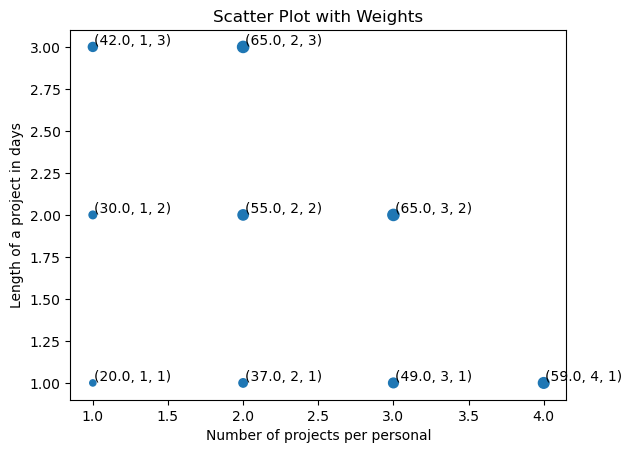

In [16]:
import matplotlib.pyplot as plt
# plot a 3d scatter with the pareto list print the labels of each point and set a different color for each point

# Create the scatter plot
plt.scatter([i[1] for i in pareto], [i[2] for i in pareto],s = [i[0] for i in pareto])
# Add a title and labels for the x and y axes
for i in pareto:
    plt.text(i[1] + 0.01, i[2]+0.01,  '%s' % (str(i)), size=10, zorder=1, color='k')
plt.title("Scatter Plot with Weights")
plt.xlabel("Number of projects per personal")
plt.ylabel("Length of a project in days")

# Show the plot
plt.show()